# playing Atari with Deep Learning

In [1]:
# choose game
game = "Pong-v0"

# generate Dataset by random play

* saving only good sequences

In [6]:
import numpy as np
import gym

env = gym.make(game)
x_data = [] # Bilder (States)
y_data = [] # Label (Aktionen)

DATASET_SIZE = 20
saved_episodes = 0

# Datensatz generieren
the_end = False
while not the_end:
    done = False
    state = env.reset()
    episode_obs = []
    episode_acts = []
  
    while not done:
        action = env.action_space.sample()
        episode_obs.append(state)
        episode_acts.append(action)
        state, reward, done, info = env.step(action)
    
        if reward < 0:
            episode_acts = []
            episode_obs = []
        elif reward > 0:
            x_data += episode_obs
            y_data += episode_acts
            episode_obs = []
            episode_acts = []
            saved_episodes += 1
            if saved_episodes % 10 == 0:
                print(saved_episodes)
            if saved_episodes+1 > DATASET_SIZE:
                print("Dataset completed")
                the_end = True

10
20
Dataset completed


# Preprocessing

In [10]:
x_data = np.array(x_data)
y_data = np.array(y_data)
x_data.shape, y_data.shape

((1418, 210, 160, 3), (1418,))

In [12]:
x_data[0].shape

(210, 160, 3)

### resize images to 80x80 pixels

In [23]:
def resize(img):
    height = 80
    width = 80
    return cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

In [24]:
resized_x_data = [resize(img) for img in x_data]
resized_x_data = np.array(resized_x_data)

Text(0.5, 1.0, 'Resized')

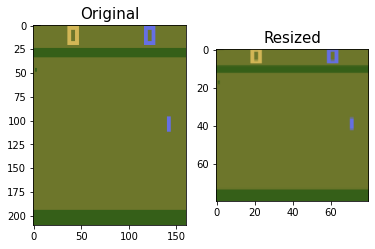

In [31]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)

axs[0].imshow(x_data[0, :, :, :])
axs[0].set_title("Original", fontsize="15")
axs[1].imshow(resized_x_data[0, :, :, :])
axs[1].set_title("Resized", fontsize="15")

### RGB to Grayscale

In [45]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    return img

In [47]:
gray_x_data = [grayscale(img) for img in resized_x_data]
gray_x_data = np.array(gray_x_data)

Text(0.5, 1.0, 'Grayscale')

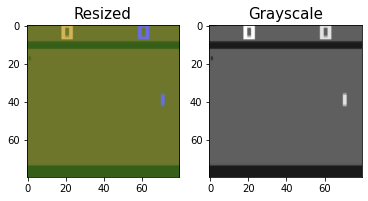

In [54]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(resized_x_data[0, :, :, :])
axs[0].set_title("Resized", fontsize="15")
axs[1].imshow(gray_x_data[0, :, :, 0], cmap="gray")
axs[1].set_title("Grayscale", fontsize="15")

### Frame Stack

In [ ]:
/*
    -Datensatz durchlaufen
    -Queue(4)
    - append Queue to Data
    -> Actions
*/


In [ ]:
# Teilen in Training und Test, shuffeln des Datensatzes
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size=0.2)

In [ ]:
len(y_train), len(y_test)

(63872, 15968)

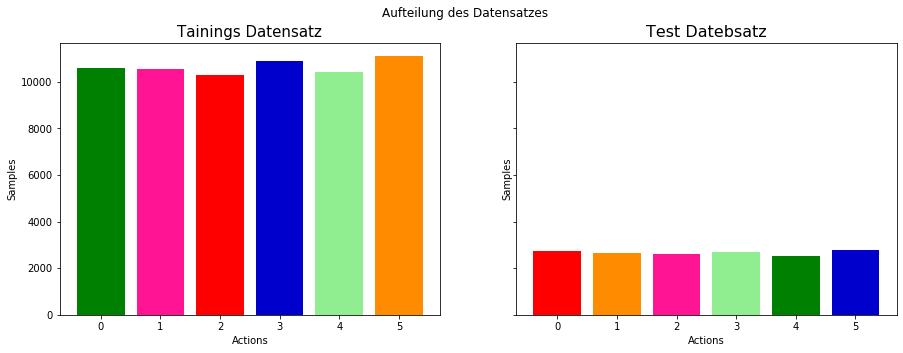

In [ ]:
count_train = Counter(y_train)
count_test = Counter(y_test)

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle("Aufteilung des Datensatzes", fontsize=22)
axs[0].bar(count_train.keys(), count_train.values(), color=colors)
axs[0].set_title("Tainings Datensatz", fontsize=15)
axs[0].set_xlabel("Actions")
axs[0].set_ylabel("Samples")

axs[1].bar(count_test.keys(), count_test.values(), color=colors)
axs[1].set_title("Test Datebsatz", fontsize=16)
axs[1].set_xlabel("Actions")
axs[1].set_ylabel("Samples")
plt.show()

In [ ]:
# konvertieren in richtiges Format
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

## 2. Erstellen des künstlichen neuronalen Netzes

In [ ]:
# Input und Output shape
INPUT_SHAPE = np.shape(x_data)[1:]
OUTPUT_SHAPE = 1

In [ ]:
import tensorflow
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

net_input = Input(shape=INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
x = Activation("relu")(x)
x = Flatten()(x)
x = Dense(512)(x)
x = Activation("relu")(x)
net_output = Dense(OUTPUT_SHAPE)(x)

LOSS_FUNCTION = Huber()
OPTIMIZER = Adam(lr=0.0005)

model = Model(inputs=net_input, outputs=net_output)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

In [ ]:
EPOCHS = 30

training = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/30


W1229 16:15:45.354696 139854935250752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1393: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1229 16:15:45.449472 139854935250752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


63872/63872 [==============================] - 17s 271us/sample - loss: 1.0660
Epoch 2/30
63872/63872 [==============================] - 15s 233us/sample - loss: 1.0555
Epoch 3/30
63872/63872 [==============================] - 14s 213us/sample - loss: 1.0534
Epoch 4/30
63872/63872 [==============================] - 14s 220us/sample - loss: 1.0532
Epoch 5/30
63872/63872 [==============================] - 15s 235us/sample - loss: 1.0524
Epoch 6/30
63872/63872 [==============================] - 14s 224us/sample - loss: 1.0520
Epoch 7/30
63872/63872 [==============================] - 14s 220us/sample - loss: 1.0514
Epoch 8/30
63872/63872 [==============================] - 14s 222us/sample - loss: 1.0511
Epoch 9/30
63872/63872 [==============================] - 14s 219us/sample - loss: 1.0516
Epoch 10/30
63872/63872 [==============================] - 15s 228us/sample - loss: 1.0516
Epoch 11/30
63872/63872 [==============================] - 14s 216us/sample - loss: 1.0511
Epoch 12/30
63872/6

In [ ]:
model.evaluate(x_test, y_test, verbose=0)

1.055940805551762

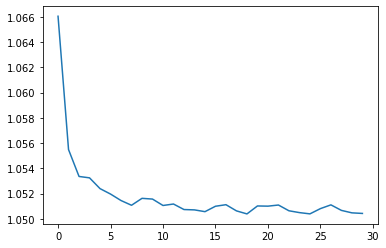

In [ ]:
import matplotlib.pyplot as plt
model_hist = training.history
plt.plot(model_hist['loss'])
plt.show()

In [ ]:
y_pred = model.predict(x_test)
y_pred

array([[2.5298357],
       [2.5298357],
       [2.5298357],
       ...,
       [2.5298357],
       [2.5298357],
       [2.5298357]], dtype=float32)

## 3. Spielen mit trainiertem neuronalen Netz

In [ ]:
EPISODES = 5

for episode in range(EPISODES):
    state = env.reset()
    state = state.reshape(1, 84, 84, 1)
    state = state.astype(np.float32)
    done = False
    Episode_Reward = 0
    while not done:
        action = model.predict(state)[0][0]
        action = int(round(action, 0))
        state, reward, done, info = env.step(action)
        state = state.reshape(1, 84, 84, 1)
        state = state.astype(np.float32)
        Episode_Reward += reward
        
        if done:
            print("Episode:", episode, "\tReward:", Episode_Reward)

Episode: 0 	Reward: -21.0
Episode: 1 	Reward: -21.0
Episode: 2 	Reward: -21.0
